In [1]:
import tensorflow as tf
from tensorflow import keras


if tf.test.gpu_device_name()=='':
    print('You do not have GPU access.')
    !nvidia-smi

else:
  print('You have GPU access')
  !nvidia-smi


# print the tensorflow version
print('TensorFlow {}; Keras {}'.format(tf.__version__, keras.__version__))
tf.test.gpu_device_name()


You have GPU access
Tue Apr  4 16:36:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 517.37       Driver Version: 517.37       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000       WDDM  | 00000000:91:00.0  On |                  Off |
| 26%   30C    P0    40W / 180W |    876MiB / 16384MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                    

'/device:GPU:0'

In [7]:
from tensorflow.keras import layers
import os
import tifffile as tiff
import numpy as np
from matplotlib import pyplot as plt
from keras.models import load_model
from preprocessing import normalizePercentile, unpatch_stack, predict_stack, patch_stack, patch_image, pad_stack, threshold_prediction_array
from window_functions import build_weighted_mask_array

model_path = os.path.abspath("F:\BactUnet\models")

#load pretrained models
model_single_name = "bactunet_V4_single_frame"
model_3frame_name = "bactunet_V4_3frame"
model_empty_name = "bactunet_V4_3frame_empty_250ep"

model_single = load_model(os.path.join(model_path, model_single_name+".hdf5"), compile=False)
model_3frame = load_model(os.path.join(model_path, model_3frame_name+".hdf5"), compile=False)
model_empty = load_model(os.path.join(model_path, model_empty_name+".hdf5"), compile=False)

modelsdict = {model_single_name:model_single, model_3frame_name:model_3frame, model_empty_name:model_empty}

print(modelsdict.keys())


dict_keys(['bactunet_V4_single_frame', 'bactunet_V4_3frame', 'bactunet_V4_3frame_empty_250ep'])


In [8]:
#models are identical except for the input shape (1, 288, 288) vs (3, 288, 288)
for l1, l2 in zip(model_single.weights, model_3frame.weights):
    print(l1.name, l1.shape, l2.name, l2.shape)

conv2d/kernel:0 (3, 3, 1, 64) conv2d/kernel:0 (3, 3, 3, 64)
conv2d/bias:0 (64,) conv2d/bias:0 (64,)
batch_normalization/gamma:0 (288,) batch_normalization/gamma:0 (288,)
batch_normalization/beta:0 (288,) batch_normalization/beta:0 (288,)
batch_normalization/moving_mean:0 (288,) batch_normalization/moving_mean:0 (288,)
batch_normalization/moving_variance:0 (288,) batch_normalization/moving_variance:0 (288,)
conv2d_1/kernel:0 (3, 3, 64, 64) conv2d_1/kernel:0 (3, 3, 64, 64)
conv2d_1/bias:0 (64,) conv2d_1/bias:0 (64,)
batch_normalization_1/gamma:0 (288,) batch_normalization_1/gamma:0 (288,)
batch_normalization_1/beta:0 (288,) batch_normalization_1/beta:0 (288,)
batch_normalization_1/moving_mean:0 (288,) batch_normalization_1/moving_mean:0 (288,)
batch_normalization_1/moving_variance:0 (288,) batch_normalization_1/moving_variance:0 (288,)
conv2d_2/kernel:0 (3, 3, 64, 128) conv2d_2/kernel:0 (3, 3, 64, 128)
conv2d_2/bias:0 (128,) conv2d_2/bias:0 (128,)
batch_normalization_2/gamma:0 (144,) bat

In [9]:
from preprocessing import patch_image, patch_stack, normalizePercentile, normalizeMinMax
from patchify import patchify

source_path = os.path.abspath(r"F:\BactUnet\Training data\stacks")
SIZE = 288

def prepare_data(source_path, PATCH_SIZE, validation=True):
    pred_dict = {}
    if validation:
        prefix = "validation"
    else:
        prefix = "training"
    stacks = os.listdir(os.path.join(source_path, prefix+"_source"))
    image_dataset = None
    mask_dataset = None
    for stack in stacks:
        if (stack.split(".")[-1]=="tif"):
            pred_dict[stack]={}
            img = tiff.imread(os.path.join(source_path, prefix+"_source",stack))
            img = normalizePercentile(img, 0.1, 99.9, clip=True)
            pred_dict[stack]["image"]=img
            mask = tiff.imread(os.path.join(source_path, prefix+"_target", stack))
            pred_dict[stack]["y_true"]=mask
            print(stack, img.shape, mask.shape)
            
            img_patch = patch_stack(img, PATCH_SIZE)
            img_patch_B = patch_stack(pad_stack(img, PATCH_SIZE), PATCH_SIZE)
            if len(mask.shape)==2:
                mask_patch = patch_image(mask, PATCH_SIZE)
            else:    
                mask_patch = patch_stack(mask, SIZE=PATCH_SIZE, DEPTH=1)
            
            print(stack, img_patch.shape, img_patch_B.shape, mask_patch.shape)
            mask_patch = normalizeMinMax(mask_patch)
            pred_dict[stack]["image_patch"] = img_patch
            pred_dict[stack]["image_patch_B"] = img_patch_B
            pred_dict[stack]["mask_patch"] = mask_patch


            #print(image_dataset.shape, mask_dataset.shape)

    return pred_dict

#Let's incorporate data from the OGM3 movie too

def prepare_OGM3_data(source_path, PATCH_SIZE):
    pred_dict = {}
    prefix = "OGM3"
    stacks = os.listdir(os.path.join(source_path, prefix+"_source"))
    image_dataset = None
    mask_dataset = None
    concat_stack = None
    concat_stack_B = None
    mask_stack = None
    for stack in sorted(stacks):
        if (stack.split(".")[-1]=="tif"):
            img = tiff.imread(os.path.join(source_path, prefix+"_source",stack))
            img = normalizePercentile(img, 0.1, 99.9, clip=True)
            img_patch = patch_stack(img, PATCH_SIZE)
            img_patch_B = patch_stack(pad_stack(img, PATCH_SIZE), PATCH_SIZE)
            #img = np.expand_dims(img, axis=0)
            mask = tiff.imread(os.path.join(source_path, prefix+"_target", stack))
            mask_patch = patch_image(mask, PATCH_SIZE)
            mask = np.expand_dims(mask, axis=0)
            
            #print(img.shape, img_patch.shape, mask.shape, mask_patch.shape)
            
            
            if concat_stack is None:
                concat_stack = img_patch
                concat_stack_B = img_patch_B
                mask_stack = mask_patch
                mask_dataset = mask
            else:
                concat_stack = np.concatenate((concat_stack, img_patch), axis=0)
                concat_stack_B = np.concatenate((concat_stack_B, img_patch_B), axis=0)
                mask_stack = np.concatenate((mask_stack, mask_patch), axis=0)
                mask_dataset = np.concatenate((mask_dataset, mask), axis=0)
    
    prefix = prefix+".tif"            
    pred_dict[prefix]={}
    
    
    pred_dict[prefix]["image_patch"]=concat_stack
    pred_dict[prefix]["image_patch_B"]=concat_stack_B
    mask_dataset = normalizeMinMax(mask_dataset)
    mask_stack = normalizeMinMax(mask_stack)
    pred_dict[prefix]["mask_patch"]=mask_stack
    pred_dict[prefix]["y_true"]=mask_dataset
        
    print(prefix, concat_stack.shape, mask_stack.shape)
            
        

            #print(image_dataset.shape, mask_dataset.shape)

    return pred_dict





#pred_dict[file]=[image_stack, mask, patch, y_true, y_pred]
image_dict = prepare_data(source_path, SIZE, validation=True)
image_dict.update(prepare_data(source_path, SIZE, validation=False))
image_dict.update(prepare_OGM3_data(source_path, SIZE))

print(image_dict.keys())
#print(prepare_OGM3_data(source_path, 288))


BT0403_229.tif (13, 2304, 2304) (11, 2304, 2304)
BT0403_229.tif (704, 3, 288, 288) (891, 3, 288, 288) (704, 1, 288, 288)
BT0407_110.tif (7, 2304, 2304) (5, 2304, 2304)
BT0407_110.tif (320, 3, 288, 288) (405, 3, 288, 288) (320, 1, 288, 288)
BT353_001.tif (12, 2304, 2304) (10, 2304, 2304)
BT353_001.tif (640, 3, 288, 288) (810, 3, 288, 288) (640, 1, 288, 288)
BT0398_210.tif (13, 2304, 2304) (11, 2304, 2304)
BT0398_210.tif (704, 3, 288, 288) (891, 3, 288, 288) (704, 1, 288, 288)
BT402_169.tif (5, 2304, 2304) (3, 2304, 2304)
BT402_169.tif (192, 3, 288, 288) (243, 3, 288, 288) (192, 1, 288, 288)
BT403_002.tif (13, 2304, 2304) (11, 2304, 2304)
BT403_002.tif (704, 3, 288, 288) (891, 3, 288, 288) (704, 1, 288, 288)
BT404_199.tif (5, 2304, 2304) (3, 2304, 2304)
BT404_199.tif (192, 3, 288, 288) (243, 3, 288, 288) (192, 1, 288, 288)
OGM3.tif (1536, 3, 288, 288) (1536, 1, 288, 288)
dict_keys(['BT0403_229.tif', 'BT0407_110.tif', 'BT353_001.tif', 'BT0398_210.tif', 'BT402_169.tif', 'BT403_002.tif', 'B

In [ ]:
keras.backend.clear_session()
stride = 2
pad_SIZE = int(SIZE / 2)

# #IOU
for stack in image_dict.keys():
    print(stack)
    y_pred1 = None
    y_pred2 = None
    y_pred3 = None
    y_pred1_B = None
    y_pred2_B = None
    y_pred3_B = None
    
    img_stack = image_dict[stack]
    for i in range(0, len(img_stack["image_patch"]), stride):
        pred_si = model_single.predict(np.expand_dims(img_stack["image_patch"][i:i+stride,1,:,:], axis=1))
        pred_3f = model_3frame.predict(img_stack["image_patch"][i:i+stride])
        pred_empt = model_empty.predict(img_stack["image_patch"][i:i+stride])
        
        if y_pred1 is not None:
            y_pred1 = np.concatenate((y_pred1, pred_si))
            y_pred2 = np.concatenate((y_pred2, pred_3f))
            y_pred3 = np.concatenate((y_pred3, pred_empt))

        else:
            y_pred1 = pred_si
            y_pred2 = pred_3f
            y_pred3 = pred_empt
            
    for i in range(0, len(img_stack["image_patch_B"]), stride):
        pred_si = model_single.predict(np.expand_dims(img_stack["image_patch_B"][i:i+stride,1,:,:], axis=1))
        pred_3f = model_3frame.predict(img_stack["image_patch_B"][i:i+stride])
        pred_empt = model_empty.predict(img_stack["image_patch_B"][i:i+stride])
        if y_pred1_B is not None:
            y_pred1_B = np.concatenate((y_pred1_B, pred_si))
            y_pred2_B = np.concatenate((y_pred2_B, pred_3f))
            y_pred3_B = np.concatenate((y_pred3_B, pred_empt))

        else:
            y_pred1_B = pred_si
            y_pred2_B = pred_3f
            y_pred3_B = pred_empt    
    
    image_dict[stack]["y_pred_single"] = unpatch_stack(y_pred1, 8, 8, 1)
    image_dict[stack]["y_pred_3frame"] = unpatch_stack(y_pred2, 8, 8, 1)
    image_dict[stack]["y_pred_empty"] = unpatch_stack(y_pred3, 8, 8, 1)
    
    image_dict[stack]["y_pred_single_B"] = unpatch_stack(y_pred1_B, 9, 9, 1)[:,0,pad_SIZE:-pad_SIZE,pad_SIZE:-pad_SIZE]
    image_dict[stack]["y_pred_3frame_B"] = unpatch_stack(y_pred2_B, 9, 9, 1)[:,0,pad_SIZE:-pad_SIZE,pad_SIZE:-pad_SIZE]
    image_dict[stack]["y_pred_empty_B"] = unpatch_stack(y_pred3_B, 9, 9, 1)[:,0,pad_SIZE:-pad_SIZE,pad_SIZE:-pad_SIZE]
    print(stack, image_dict[stack]["y_pred_single_B"].shape, image_dict[stack]["y_pred_3frame_B"].shape, image_dict[stack]["y_pred_empty_B"].shape)
    

BT0403_229.tif
BT0403_229.tif (11, 2304, 2304) (11, 2304, 2304) (11, 2304, 2304)
BT0407_110.tif
BT0407_110.tif (5, 2304, 2304) (5, 2304, 2304) (5, 2304, 2304)
BT353_001.tif
BT353_001.tif (10, 2304, 2304) (10, 2304, 2304) (10, 2304, 2304)
BT0398_210.tif
BT0398_210.tif (11, 2304, 2304) (11, 2304, 2304) (11, 2304, 2304)
BT402_169.tif
BT402_169.tif (3, 2304, 2304) (3, 2304, 2304) (3, 2304, 2304)
BT403_002.tif
BT403_002.tif (11, 2304, 2304) (11, 2304, 2304) (11, 2304, 2304)
BT404_199.tif
BT404_199.tif (3, 2304, 2304) (3, 2304, 2304) (3, 2304, 2304)
OGM3.tif


In [12]:
import pickle

pickle.dump(image_dict, open("train_val_image_dict.p", "wb"))
image_dict = pickle.read(open("train_val_image_dict.p", "rb"))

In [15]:
for filename in image_dict.keys():
    for stack in image_dict[filename].keys():
        print(stack, image_dict[filename][stack].shape, image_dict[filename][stack].dtype)
    

image (13, 2304, 2304) float32
y_true (11, 2304, 2304) uint8
image_patch (704, 3, 288, 288) float32
image_patch_B (891, 3, 288, 288) float32
mask_patch (704, 1, 288, 288) float32
y_pred_single (11, 1, 2304, 2304) float32
y_pred_3frame (11, 1, 2304, 2304) float32
y_pred_empty (11, 1, 2304, 2304) float32
y_pred_single_B (8, 2304, 2304) float32
y_pred_3frame_B (8, 2304, 2304) float32
y_pred_empty_B (8, 2304, 2304) float32
image (7, 2304, 2304) float32
y_true (5, 2304, 2304) uint8
image_patch (320, 3, 288, 288) float32
image_patch_B (405, 3, 288, 288) float32
mask_patch (320, 1, 288, 288) float32
y_pred_single (5, 1, 2304, 2304) float32
y_pred_3frame (5, 1, 2304, 2304) float32
y_pred_empty (5, 1, 2304, 2304) float32
y_pred_single_B (3, 2304, 2304) float32
y_pred_3frame_B (3, 2304, 2304) float32
y_pred_empty_B (3, 2304, 2304) float32
image (12, 2304, 2304) float32
y_true (10, 2304, 2304) uint8
image_patch (640, 3, 288, 288) float32
image_patch_B (810, 3, 288, 288) float32
mask_patch (640, 1

In [11]:
threshold = 0.5

for stack in image_dict.keys():
    pred_si = (image_dict[stack]["y_pred_single"]>threshold)*255
    pred_3f = (image_dict[stack]["y_pred_3frame"]>threshold)*255
    pred_empty = (image_dict[stack]["y_pred_empty"]>threshold)*255
    pred_si_B = (image_dict[stack]["y_pred_single_B"]>threshold)*255
    pred_3f_B = (image_dict[stack]["y_pred_3frame_B"]>threshold)*255
    pred_empty_B = (image_dict[stack]["y_pred_empty_B"]>threshold)*255
    y_trye = image_dict[stack]["y_true"]
    
    saveme = np.concatenate((np.expand_dims(image_dict[stack]["y_true"],axis=1), pred_si, pred_3f, pred_empty, pred_si_B, pred_3f_B, pred_empty_B), axis=1)
    saveme = saveme.astype('uint8')
    prefix="AB_compare"
    dic = unpatch_stack(image_dict[stack]["image_patch"], 8, 8, 3)
    dic = dic[:,1,:,:] * 255
    dic = np.expand_dims(dic, axis=1).astype('uint8')
    print(dic.shape, image_dict[stack]["image_patch"].max())
    saveme = np.concatenate((dic, saveme), axis=1)
    tiff.imwrite(os.path.join(source_path, predict, prefix+stack), saveme, imagej=True,
                      metadata={'unit': 'um', 'finterval': 15,
                                'axes': 'TCYX'})

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 4 dimension(s) and the array at index 4 has 3 dimension(s)

In [7]:
#Quick look at the training
import pandas as pd
import seaborn as sns

log_si = pd.read_csv("models/"+model_single_name+".csv")
log_3m = pd.read_csv("models/"+model_3frame_name+".csv")
log_empt = pd.read_csv("models/"+model_empty_name+".csv")

log_si["Model"] = "single"
log_3m["Model"] = "3frame"
log_empt["Model"] = "empty"

train_logs = pd.concat([log_si, log_3m, log_empt], ignore_index=True)

train_logs.head()



,epoch,dice_coef,iou_seg,loss,val_dice_coef,val_iou_seg,val_loss,Model
0,0,0.405609,0.734618,1.388661,0.482242,0.674140,1.311090,single
1,1,0.530784,0.632071,1.169838,0.527189,0.634532,1.232484,single
2,2,0.562878,0.601784,1.111608,0.547631,0.614936,1.191722,single
3,3,0.572708,0.592058,1.088279,0.542584,0.619917,1.200951,single
4,4,0.585001,0.580063,1.067117,0.510874,0.649524,1.274522,single


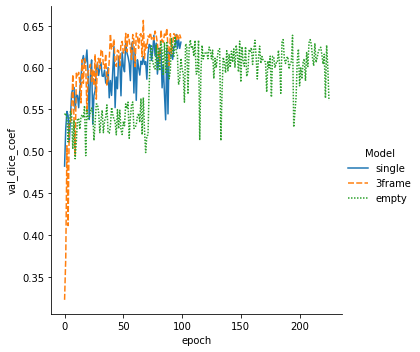

In [23]:
g1 = sns.relplot(data=train_logs, x='epoch', y='val_dice_coef', style='Model', hue='Model', kind='line')
#g1.set(ylim=(0,150))


In [7]:
def dice_score(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3) # for easy reading
    return dice    

def iou_score(mask1, mask2):
    intersection = np.logical_and(mask1, mask1)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score
    

for stack in image_dict.keys():
    for frame in range(len(image_dict[stack]['y_pred_single'])):
        dice_comp = dice_score(image_dict[stack]['y_pred_single'][frame], image_dict[stack]['y_pred_3frame'][frame])
        iou_comp = iou_score(image_dict[stack]['y_pred_single'][frame], image_dict[stack]['y_pred_3frame'][frame])
        print(stack, frame, dice_comp, iou_comp)


BT0403_229.tif 0 0.768 0.9998950711114569
BT0403_229.tif 1 0.785 0.9999054312063832
BT0403_229.tif 2 0.795 0.9998653058095017
BT0403_229.tif 3 0.787 0.9999165445919388
BT0403_229.tif 4 0.796 0.9998888520070125
BT0403_229.tif 5 0.791 0.9998856495023493
BT0403_229.tif 6 0.765 0.9998977059186451
BT0403_229.tif 7 0.78 0.9998960108480278
BT0403_229.tif 8 0.771 0.9998762291836137
BT0403_229.tif 9 0.756 0.9999007182011419
BT0403_229.tif 10 0.752 0.9999095732195061
BT0407_110.tif 0 0.739 0.9999900158503086
BT0407_110.tif 1 0.61 0.9999917112750771
BT0407_110.tif 2 0.673 0.9999939718352842
BT0407_110.tif 3 0.734 0.9999826689872642
BT0407_110.tif 4 0.754 0.9999918996551891
BT0398_210.tif 0 0.829 0.9999299193111294
BT0398_210.tif 1 0.87 0.999926904055167
BT0398_210.tif 2 0.828 0.9999020393153905
BT0398_210.tif 3 0.865 0.9998960102407306
BT0398_210.tif 4 0.847 0.9999250213538431
BT0398_210.tif 5 0.857 0.9999171085815414
BT0398_210.tif 6 0.813 0.9998890366307226
BT0398_210.tif 7 0.843 0.999928787474

In [8]:
from skimage import measure

threshold = 0.5
stack = 'BT0407_110.tif'
i = 3

contours_true = measure.find_contours(image_dict[stack]['y_true'][i]>1)
contours_single = measure.find_contours(image_dict[stack]["y_pred_single"][i,0,:,:]>threshold)
contours_3frame = measure.find_contours(image_dict[stack]["y_pred_3frame"][i,0,:,:]>threshold)

print(len(contours_true), len(contours_single), len(contours_3frame))


37 44 55


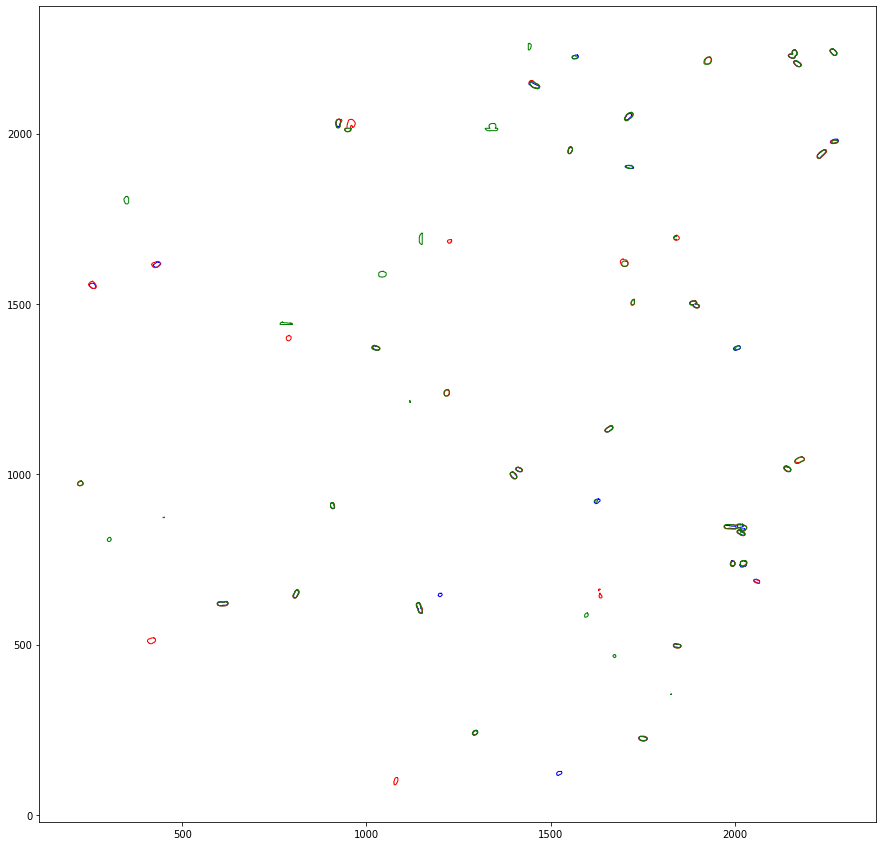

In [9]:
fig, ax = plt.subplots(figsize=(15, 15))
for contour in contours_true:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='blue')
    
for contour in contours_single:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='red')
    
for contour in contours_3frame:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='green')

plt.show()


37 44 55 31 32 44


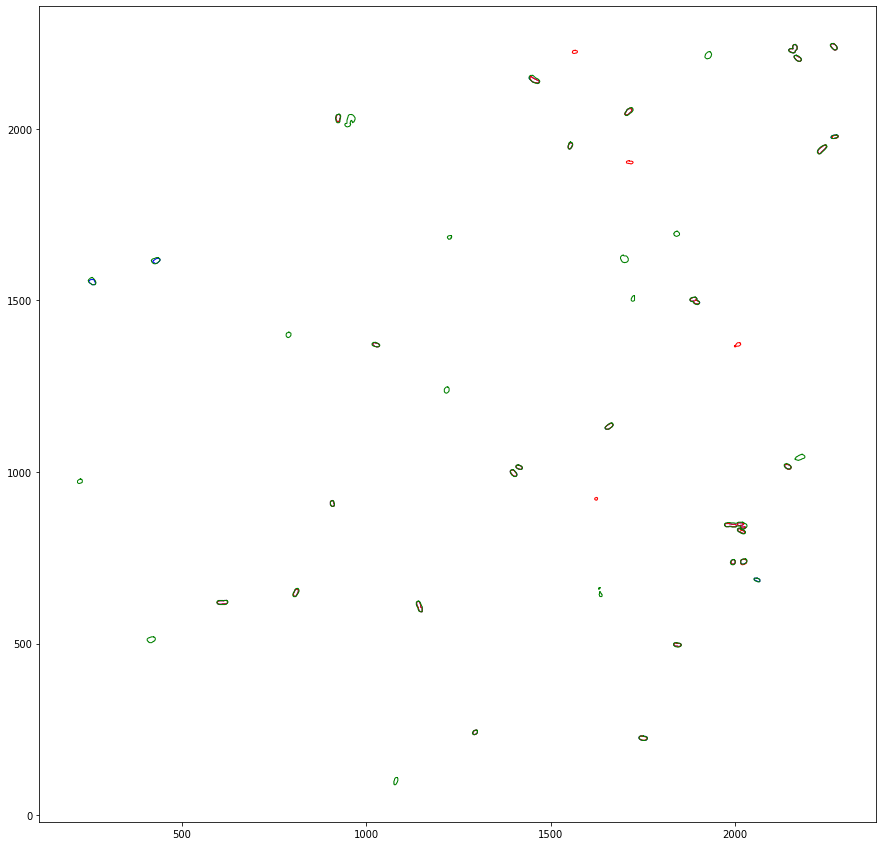

In [10]:
#ANDing two masks gives a quick count of whow well they agree

mask_true = image_dict[stack]['y_true'][i]>1
mask_single = image_dict[stack]["y_pred_single"][i,0,:,:]>threshold
mask_3frame = image_dict[stack]["y_pred_3frame"][i,0,:,:]>threshold

and_mask = np.logical_and(mask_true, mask_single)
and_mask2 = np.logical_and(mask_true, mask_3frame)
and_mask3 = np.logical_and(mask_single, mask_single)

contours_and = measure.find_contours(and_mask)
contours_and2 = measure.find_contours(and_mask2)
contours_and3 = measure.find_contours(and_mask3)

print(len(contours_true), len(contours_single), len(contours_3frame), len(contours_and), len(contours_and2), len(contours_and3))

fig, ax = plt.subplots(figsize=(15, 15))
for contour in contours_and:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='blue')
for contour in contours_and2:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='red')
for contour in contours_and3:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='green')

plt.show()


In [10]:
count_compare = {}
threshold = 0.5 

def countmask(mask):
    #counts contours in binary 3D-array
    out=[]
    for frame in range(len(mask)):
        out.append(len(measure.find_contours(mask[frame])))
    return out
    
    
for stack in image_dict.keys():
    count_compare[stack] = {}
    mask_true = image_dict[stack]['y_true']>1
    mask_single = image_dict[stack]["y_pred_single"][:,0,:,:]>threshold
    mask_3frame = image_dict[stack]["y_pred_3frame"][:,0,:,:]>threshold
    mask_empty = image_dict[stack]["y_pred_empty"][:,0,:,:]>threshold
    
    and_single = np.logical_and(mask_true, mask_single)
    and_3frame = np.logical_and(mask_true, mask_3frame)
    and_empty = np.logical_and(mask_true, mask_empty)
    
    single_and_3frame = np.logical_and(mask_single, mask_single)
     
    count_compare[stack]['frame'] = list(range(len(mask_true)))
    count_compare[stack]['true'] = countmask(mask_true)
    count_compare[stack]['single'] = countmask(mask_single)
    count_compare[stack]['3frame'] = countmask(mask_3frame)
    count_compare[stack]['empty'] = countmask(mask_empty)
    count_compare[stack]['true_and_single'] = countmask(and_single)
    count_compare[stack]['true_and_3frame'] = countmask(and_3frame)
    count_compare[stack]['true_and_empty'] = countmask(and_empty)
    count_compare[stack]['3frame_and_single'] = countmask(single_and_3frame)




In [11]:
count_df = None
#print(count_compare)
for stack in count_compare.keys():
    df = pd.DataFrame.from_dict(count_compare[stack])
    df['file'] = stack
    
    
    if count_df is None:
        count_df = df
    
    else:
        count_df = pd.concat([count_df, df], ignore_index=True)
count_df.head()

,frame,true,single,3frame,empty,true_and_single,true_and_3frame,true_and_empty,3frame_and_single,file
0,0,81,96,111,79,65,72,67,96,BT0403_229.tif
1,1,76,102,126,106,63,65,63,102,BT0403_229.tif
2,2,77,102,135,118,68,64,67,102,BT0403_229.tif
3,3,78,114,130,120,70,68,70,114,BT0403_229.tif
4,4,82,119,123,108,74,74,70,119,BT0403_229.tif


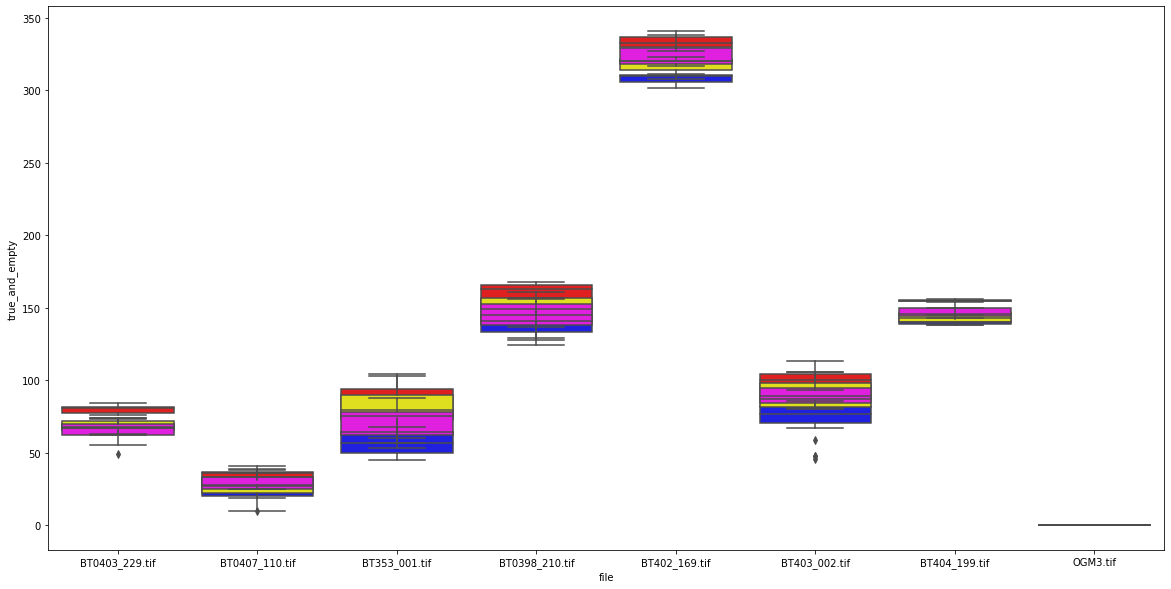

In [12]:
plt.figure(figsize=(20,10))
g1 = sns.boxplot(data=count_df, x='file', y='true', color='red')
g1 = sns.boxplot(data=count_df, x='file', y='true_and_single', color='blue')
g1 = sns.boxplot(data=count_df, x='file', y='true_and_3frame', color='yellow')
g1 = sns.boxplot(data=count_df, x='file', y='true_and_empty', color='magenta')

In [13]:
count_df['TP_fraction_single'] = count_df['true_and_single']/count_df['true']
count_df['TP_fraction_3frame'] = count_df['true_and_3frame']/count_df['true']
count_df['TP_fraction_empty'] = count_df['true_and_empty']/count_df['true']

count_df['FP_fraction_single'] = (count_df['single']-count_df['true_and_single'])/count_df['single']
count_df['FP_fraction_3frame'] = (count_df['3frame']-count_df['true_and_3frame'])/count_df['3frame']
count_df['FP_fraction_empty'] = (count_df['empty']-count_df['true_and_empty'])/count_df['empty']
count_df.head()


,frame,true,single,3frame,empty,true_and_single,true_and_3frame,true_and_empty,3frame_and_single,file,TP_fraction_single,TP_fraction_3frame,TP_fraction_empty,FP_fraction_single,FP_fraction_3frame,FP_fraction_empty
0,0,81,96,111,79,65,72,67,96,BT0403_229.tif,0.802469,0.888889,0.827160,0.322917,0.351351,0.151899
1,1,76,102,126,106,63,65,63,102,BT0403_229.tif,0.828947,0.855263,0.828947,0.382353,0.484127,0.405660
2,2,77,102,135,118,68,64,67,102,BT0403_229.tif,0.883117,0.831169,0.870130,0.333333,0.525926,0.432203
3,3,78,114,130,120,70,68,70,114,BT0403_229.tif,0.897436,0.871795,0.897436,0.385965,0.476923,0.416667
4,4,82,119,123,108,74,74,70,119,BT0403_229.tif,0.902439,0.902439,0.853659,0.378151,0.398374,0.351852


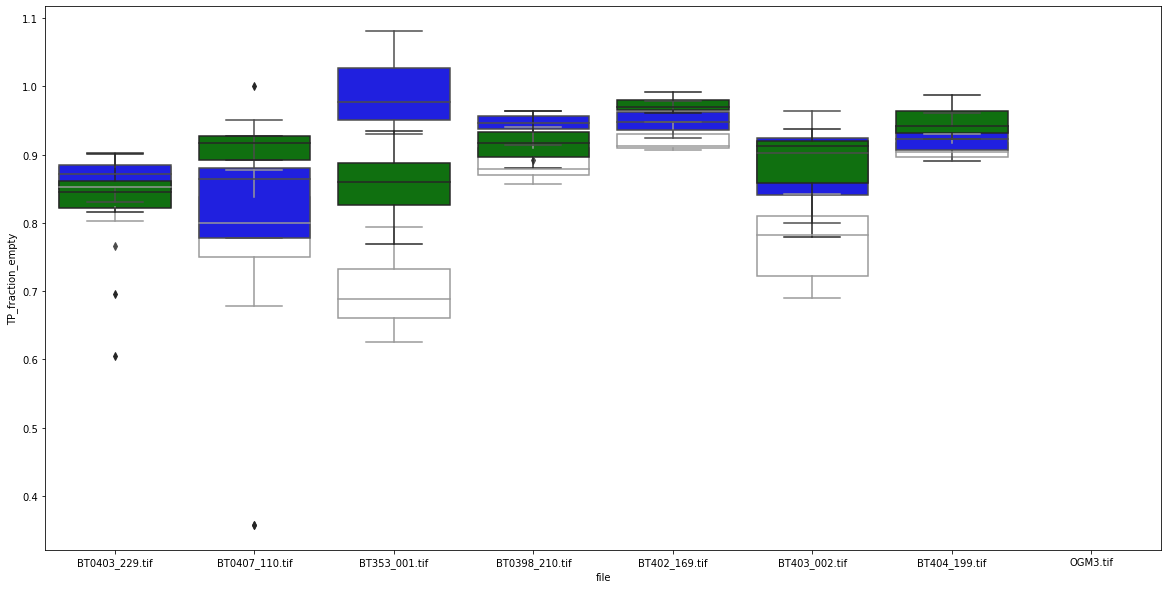

In [14]:
plt.figure(figsize=(20,10))
g1 = sns.boxplot(data=count_df, x='file', y='TP_fraction_single', color='white')
g1 = sns.boxplot(data=count_df, x='file', y='TP_fraction_3frame', color='blue')
g1 = sns.boxplot(data=count_df, x='file', y='TP_fraction_empty', color='green')





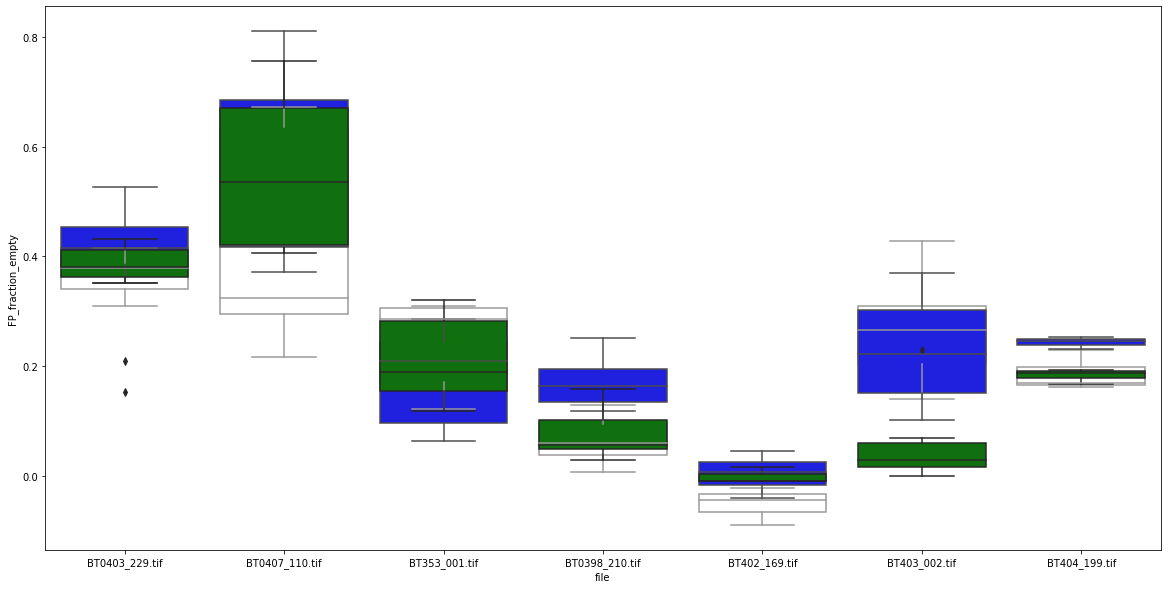

In [33]:
plt.figure(figsize=(20,10))
g2 = sns.boxplot(data=count_df, x='file', y='FP_fraction_single', color='white')
g2 = sns.boxplot(data=count_df, x='file', y='FP_fraction_3frame', color='blue')
g2 = sns.boxplot(data=count_df, x='file', y='FP_fraction_empty', color='green')

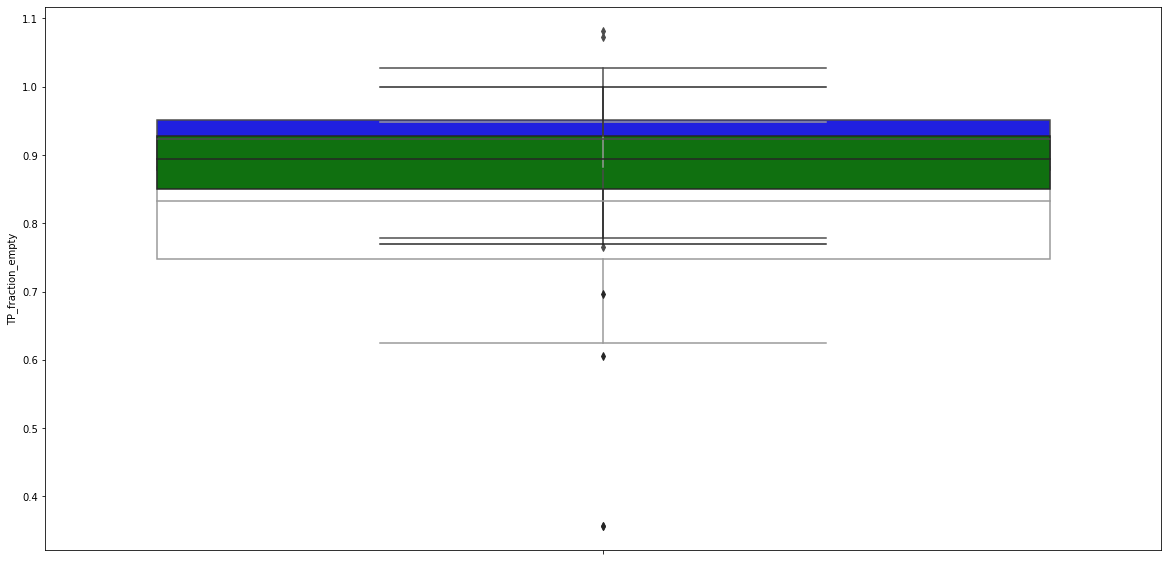

In [34]:
plt.figure(figsize=(20,10))
g1 = sns.boxplot(data=count_df, y='TP_fraction_single', color='white')
g1 = sns.boxplot(data=count_df, y='TP_fraction_3frame', color='blue')
g1 = sns.boxplot(data=count_df, y='TP_fraction_empty', color='green')


Let's reformat the dataframe for easier plottting

In [35]:
count_df.head()

,frame,true,single,3frame,empty,true_and_single,true_and_3frame,true_and_empty,3frame_and_single,file,TP_fraction_single,TP_fraction_3frame,TP_fraction_empty,FP_fraction_single,FP_fraction_3frame,FP_fraction_emty,FP_fraction_empty
0,0,81,96,111,79,65,72,67,96,BT0403_229.tif,0.802469,0.888889,0.827160,0.322917,0.351351,0.151899,0.151899
1,1,76,102,126,106,63,65,63,102,BT0403_229.tif,0.828947,0.855263,0.828947,0.382353,0.484127,0.405660,0.405660
2,2,77,102,135,118,68,64,67,102,BT0403_229.tif,0.883117,0.831169,0.870130,0.333333,0.525926,0.432203,0.432203
3,3,78,114,130,120,70,68,70,114,BT0403_229.tif,0.897436,0.871795,0.897436,0.385965,0.476923,0.416667,0.416667
4,4,82,119,123,108,74,74,70,119,BT0403_229.tif,0.902439,0.902439,0.853659,0.378151,0.398374,0.351852,0.351852


In [36]:
single = count_df.filter(items=['file', 'frame'])
single['model'] = 'single_frame'
single['TP'] = count_df['true_and_single']
single['FN'] = count_df['true']-count_df['true_and_single']
single['FP'] = count_df['single']-count_df['true_and_single']

multi = count_df.filter(items=['file', 'frame'])
multi['model'] = '3_frame'
multi['TP'] = count_df['true_and_3frame']
multi['FN'] = count_df['true']-count_df['true_and_3frame']
multi['FP'] = count_df['3frame']-count_df['true_and_3frame']

empty = count_df.filter(items=['file', 'frame'])
empty['model'] = 'empty'
empty['TP'] = count_df['true_and_empty']
empty['FN'] = count_df['true']-count_df['true_and_empty']
empty['FP'] = count_df['empty']-count_df['true_and_empty']

tp_df = pd.concat([single, multi, empty], ignore_index=True)

tp_df['precision'] = tp_df['TP']/(tp_df['TP']+tp_df['FP'])
tp_df['recall'] = tp_df['TP']/(tp_df['TP']+tp_df['FN'])
tp_df['average_precision'] = tp_df['TP']/(tp_df['TP']+tp_df['FP']+tp_df['FN'])

tp_df.head()
tp_df.to_csv('single_3frame_empty_count.csv') 

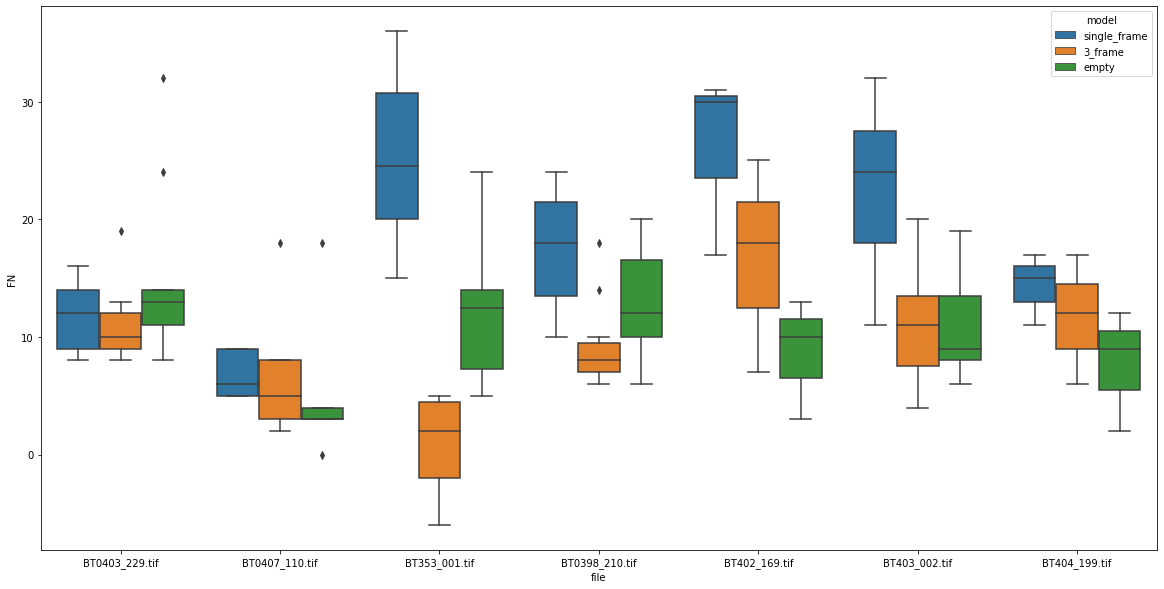

In [54]:
plt.figure(figsize=(20,10))
g3 = sns.boxplot(data=tp_df, x='file', y='FN', hue='model')

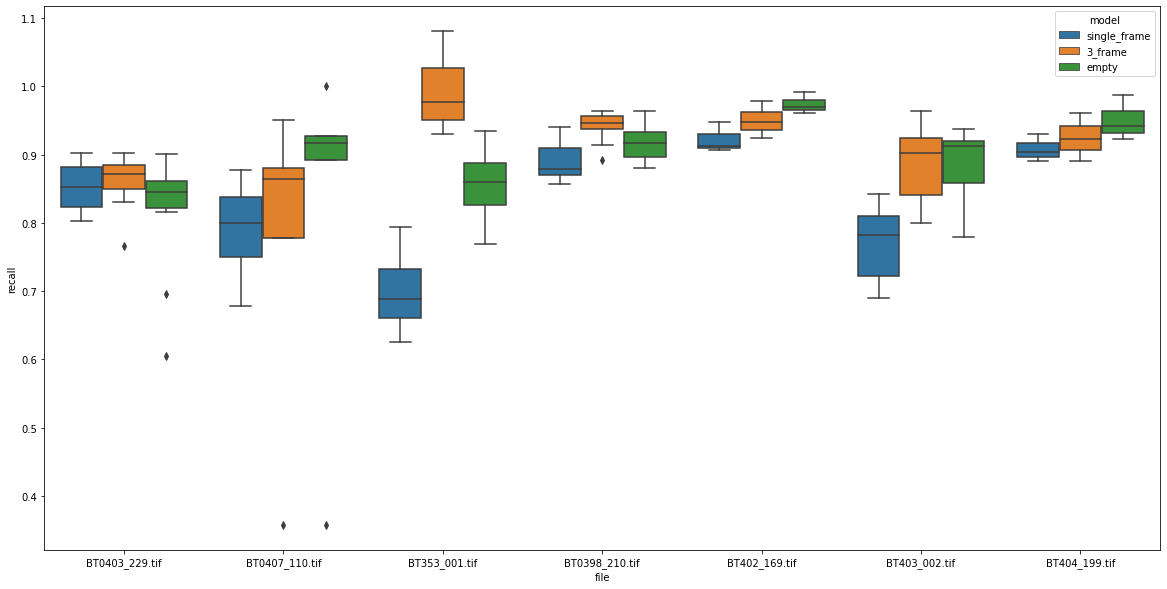

In [38]:
plt.figure(figsize=(20,10))
g3 = sns.boxplot(data=tp_df, x='file', y='recall', hue='model')

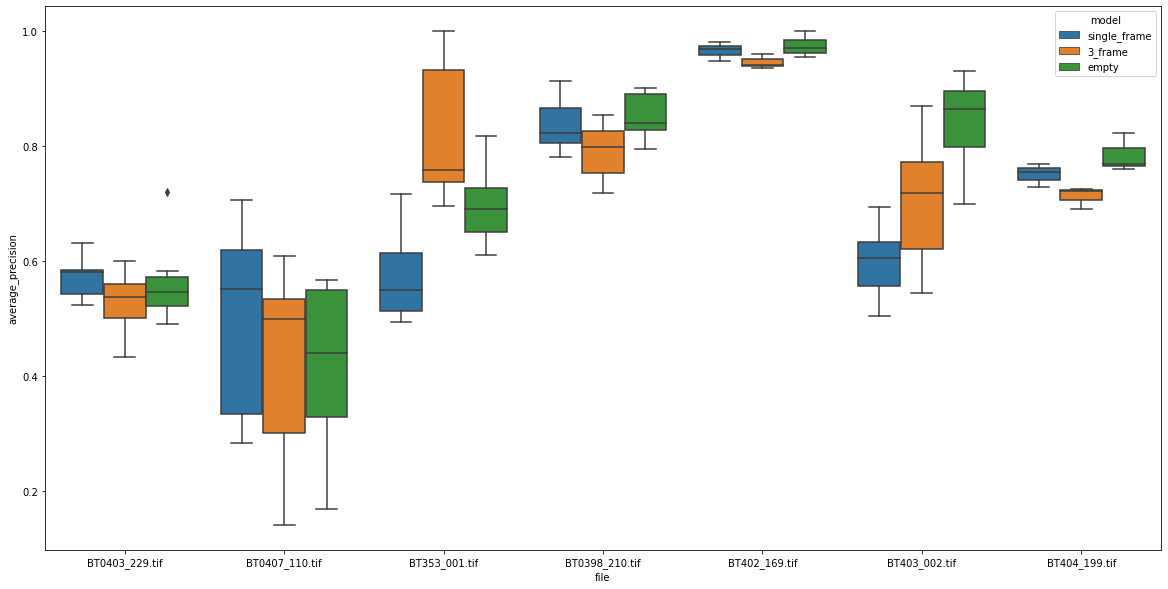

In [39]:
plt.figure(figsize=(20,10))
g3 = sns.boxplot(data=tp_df, x='file', y='average_precision', hue='model')

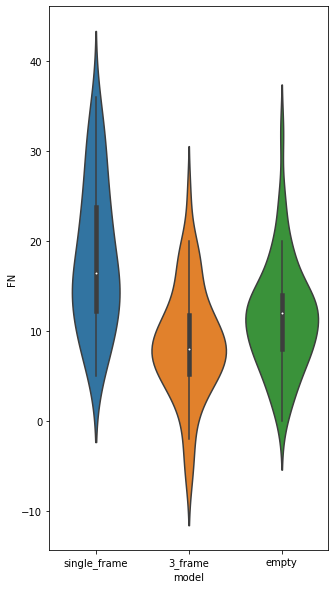

In [57]:
plt.figure(figsize=(5,10))
g3 = sns.violinplot(data=tp_df, x='model', y='FN')

In [59]:
tp_df['F1-score'] = 2*tp_df['precision']*tp_df['recall']/(tp_df['precision']+tp_df['recall'])

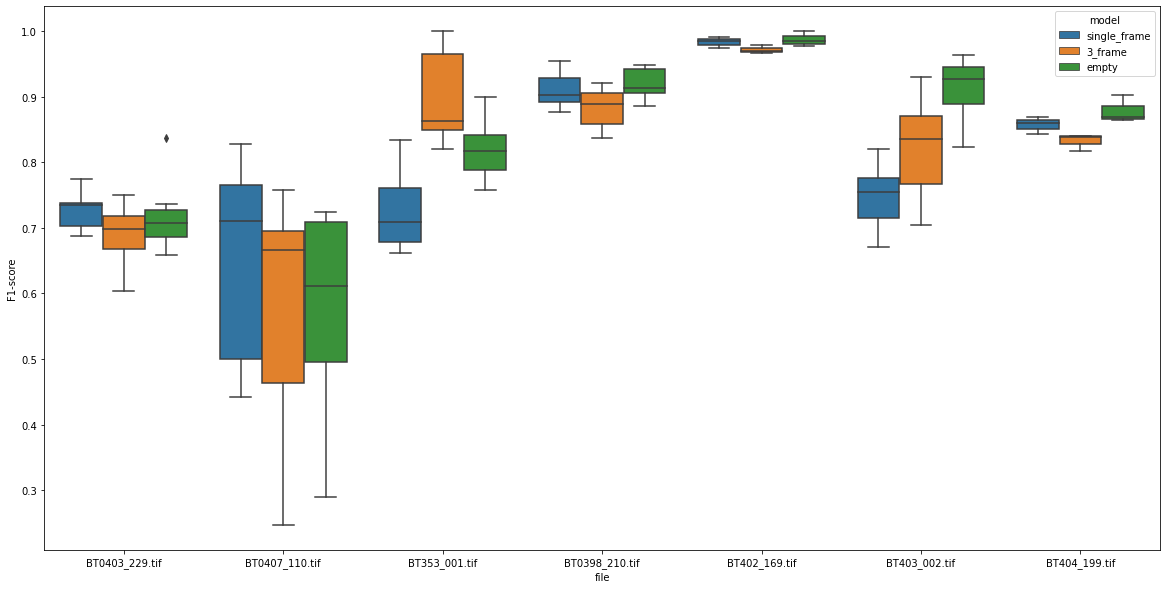

In [62]:
plt.figure(figsize=(20,10))
g3 = sns.boxplot(data=tp_df, x='file', y='F1-score', hue='model')

In [70]:
keras.backend.clear_session()
stride = 2

# #IOU
for stack in ogm3_data.keys():
    y_pred1 = None
    y_pred2 = None
    y_pred3 = None
    
    img_stack = ogm3_data[stack]
    for i in range(0, len(img_stack["image_patch"]), stride):
        pred_si = model_single.predict(np.expand_dims(img_stack["image_patch"][i:i+stride,1,:,:], axis=1))
        pred_3f = model_3frame.predict(img_stack["image_patch"][i:i+stride])
        pred_empt = model_empty.predict(img_stack["image_patch"][i:i+stride])
        if y_pred1 is not None:
            y_pred1 = np.concatenate((y_pred1, pred_si))
            y_pred2 = np.concatenate((y_pred2, pred_3f))
            y_pred3 = np.concatenate((y_pred3, pred_empt))

        if y_pred1 is None:
            y_pred1 = pred_si
            y_pred2 = pred_3f
            y_pred3 = pred_empt
    
    ogm3_data[stack]["y_pred_single"] = unpatch_stack(y_pred1, 8, 8, 1)
    ogm3_data[stack]["y_pred_3frame"] = unpatch_stack(y_pred2, 8, 8, 1)
    ogm3_data[stack]["y_pred_empty"] = unpatch_stack(y_pred3, 8, 8, 1)
    print(stack, ogm3_data[stack]["y_pred_single"].shape, ogm3_data[stack]["y_pred_3frame"].shape, ogm3_data[stack]["y_pred_empty"].shape)
    

OGM3 (24, 1, 2304, 2304) (24, 1, 2304, 2304) (24, 1, 2304, 2304)


In [71]:
threshold = 0.5

for stack in ogm3_data.keys():
    pred_si = (ogm3_data[stack]["y_pred_single"]>threshold)*255
    pred_3f = (ogm3_data[stack]["y_pred_3frame"]>threshold)*255
    pred_empty = (ogm3_data[stack]["y_pred_empty"]>threshold)*255
    
    saveme = np.concatenate((np.expand_dims(ogm3_data[stack]["y_true"],axis=1), pred_si, pred_3f, pred_empty), axis=1)
    saveme = saveme.astype('uint8')
    prefix="V4_compare"
    dic = unpatch_stack(ogm3_data[stack]["image_patch"], 8, 8, 3)
    dic = dic[:,1,:,:] * 255
    dic = np.expand_dims(dic, axis=1).astype('uint8')
    print(dic.shape, ogm3_data[stack]["image_patch"].max())
    saveme = np.concatenate((dic, saveme), axis=1)
    tiff.imwrite(os.path.join(r"C:\Users\Jens\Documents\Code\BactUnet\Bactnet\Training data\stacks\predict", "OGM3.tif"), saveme, imagej=True,
                      metadata={'unit': 'um', 'finterval': 15,
                                'axes': 'TCYX'})

(24, 1, 2304, 2304) 1.0
